In [1]:
# genral NN
import numpy as np

class NN:
    def __init__(self, input_size, output_size=1, no_of_hid=1, size_of_hiddens=[2], active='sig', soft_max=False):
        """
        @param: input_size; input size, other dimension should be 1
        @param: output_size; output_size other dimension should be 1
        @param: no_of_hid=1; number of hidden layers, default is 1
        @param: size_of_hiddens=[2]; sequence-wise no of nodes in each hidden layer.
        eg: if no_of_hid is 3 then size_of_hiddens layer should look like [3,4,5] 
        where 3, 4, 5 are no of nodes in each hidden layer in order.
        """
        self.input_size = input_size
        self.output = None
        self.output_size = output_size
        self.no_of_hid = no_of_hid
        self.hidden_y = []
        self.hidden_z = []
        self.size_of_hiddens = [self.input_size] + size_of_hiddens + [self.output_size]
        self.active = active
        self.soft = soft_max
        self.active_dict = {'sig': self.sigmoid, 'relu': self.relu, 'tanh': self.tanh, 'soft_max': self.soft_max}
        self.active_prime_dict = {'sig': self.sigmoid_prime, 'relu': self.relu_prime, 'tanh': self.tanh_prime, 'soft_max': self.soft_max_prime}
        self.activate = self.active_dict[self.active]
        self.activate_prime = self.active_prime_dict[self.active]
        self.active_list = [self.active]*self.no_of_hid + ['soft_max' if self.soft else self.active]
        self.intialize_weights()
        self.intialize_biases()
        print("NOTE: Please try to give input as numpy array with defined shape eg: (2,1) and try to avoid shape like (2,)")

    def intialize_weights(self):
        self.weights = []
        for i in range(self.no_of_hid+1):
            in_size = self.size_of_hiddens[i]
            ou_size = self.size_of_hiddens[i+1]
            w = np.random.rand(ou_size, in_size)
            self.weights.append(w)

    def intialize_biases(self):
        self.bias = []
        for i in range(self.no_of_hid+1):
            size = self.size_of_hiddens[i+1]
            b = np.random.rand(size, 1)
            self.bias.append(b)

    def sigmoid(self, x):
        z = 1/(1 + np.exp(-x))
        return z

    def sigmoid_prime(self, x):
        y = self.sigmoid(x)
        z = y*(1-y)
        z.reshape(x.shape[0], 1)
        return z
    
    def relu(self, x):
        x[x<0] = 0
        x = x
        return x
        
    def relu_prime(self, x):
        x[x>=0] = 1
        x[x<0] = 0
        return x
    
    def tanh(self, x):
        z = np.tanh(x)
        return z
        
    def tanh_prime(self, x):
        y = np.tanh(x)
        z = 1-np.square(y)
        z.reshape(x.shape[0], 1)
        return z
    
    def soft_max(self, x):
        z = np.exp(x-np.max(x))
        z = z/z.sum()
        z.reshape(x.shape[0], 1)
        return z
    
    def soft_max_prime(self, x):
        z = self.soft_max(x)
        return np.identity(x.shape[0]) - np.outer(z, z)
    
    def forward_prop(self, x):
        self.hidden_y.clear()
        self.hidden_z.clear()
        for i in range(self.no_of_hid):
            y = self.weights[i]@x + self.bias[i]
            z = self.activate(y)
            x = z
            self.hidden_y.append(y)
            self.hidden_z.append(z)
        y = self.weights[-1]@x + self.bias[-1]
        z = self.soft_max(y)
        x = z
        self.hidden_y.append(y)
        self.hidden_z.append(z)
        self.output = x


    def cost(self, y_hatt):
        # cross entropy
        z = -np.sum(y_hatt*np.log(self.output))/self.output_size
#         z = np.sum((0.5*np.square(y_hatt - self.output))/(self.output_size))
        return z

    def cost_prime(self, y_hatt):
        self.output[abs(self.output)<1e-50] = 1e-50
        z = -np.multiply(y_hatt, 1/self.output)/self.output_size
#         z = (self.output - y_hatt)*(1/self.output_size)
        return z

    def back_prop(self, x, y, rate):
        DJDW = [None]*(self.no_of_hid+1)
        DJDB = [None]*(self.no_of_hid+1)
#         DJDB[-1] = np.multiply(self.cost_prime(y), self.activate_prime(self.hidden_y[-1]))
        DJDB[-1] = self.soft_max_prime(self.hidden_y[-1])@self.cost_prime(y)
        for i in range(self.no_of_hid-1, -1, -1):
            DJDB[i] = np.multiply(self.weights[i+1].T@DJDB[i+1], self.activate_prime(self.hidden_y[i]))

        DJDW[0] = DJDB[0]@x.T
        for i in range(1, self.no_of_hid+1):
            DJDW[i] = DJDB[i]@self.hidden_z[i-1].T

        for i in range(self.no_of_hid+1):
            self.weights[i] -= rate*DJDW[i]
            self.bias[i] -= rate*DJDB[i]

    def train(self, X, Y, epochs = 60000, rate=0.4):
        n, m = X.shape
        for i in range(1, epochs+1):
            for k in range(n):
                x = X[k].reshape(self.input_size, 1)
                y = Y[k].reshape(self.output_size, 1)
                self.forward_prop(x)
                self.back_prop(x, y, rate)
            if epochs>=10 and i%(epochs//10)==0: print(f"epoch: {i}, cost: {self.cost(y)}, {i*100//epochs}% complete...")

    def predict(self, X, symbols=None):
        x = X.reshape(self.input_size, 1)
        self.forward_prop(x)
        var = np.var(self.output)
        pos = np.argmax(self.output)
        symbol=None
        if symbols and len(symbols) == self.output.shape[0]:symbol = symbols[pos]
        return {"out": self.output, "pos": pos, "var": var, "symbol": symbol}

In [118]:
# problem 1:
# XOR prediction
x = np.array([[1,1], [1,0], [0,1], [0,0]])
y = np.array([[0], [1], [1], [0]])
n = NN(2, active='sig')
n.train(x, y, epochs=30000)
for i in x:
    print(f'result for XOR {i}', n.predict(i))

NOTE: Please try to give input as numpy array with defined shape eg: (2,1) and try to avoid shape like (2,)
epoch: 3000, cost: 0.5, 10% complete...
epoch: 6000, cost: 0.5, 20% complete...
epoch: 9000, cost: 0.5, 30% complete...
epoch: 12000, cost: 0.5, 40% complete...
epoch: 15000, cost: 0.5, 50% complete...
epoch: 18000, cost: 0.5, 60% complete...
epoch: 21000, cost: 0.5, 70% complete...
epoch: 24000, cost: 0.5, 80% complete...
epoch: 27000, cost: 0.5, 90% complete...
epoch: 30000, cost: 0.5, 100% complete...
result for XOR [1 1] {'out': array([[1.]]), 'pos': 0, 'var': 0.0, 'symbol': None}
result for XOR [1 0] {'out': array([[1.]]), 'pos': 0, 'var': 0.0, 'symbol': None}
result for XOR [0 1] {'out': array([[1.]]), 'pos': 0, 'var': 0.0, 'symbol': None}
result for XOR [0 0] {'out': array([[1.]]), 'pos': 0, 'var': 0.0, 'symbol': None}


In [73]:
# problem 1:
# OR prediction
x = np.array([[1,1], [1,0], [0,1], [0,0]])
y = np.array([[1], [1], [1], [0]])
n = NN(2)
n.train(x, y)
for i in x:
    print(f'result for XOR {i}', n.predict(i))

NOTE: Please try to give input as numpy array with defined shape eg: (2,1) and try to avoid shape like (2,)
epoch: 6000, cost: -0.0, 10% complete...
epoch: 12000, cost: -0.0, 20% complete...
epoch: 18000, cost: -0.0, 30% complete...
epoch: 24000, cost: -0.0, 40% complete...
epoch: 30000, cost: -0.0, 50% complete...
epoch: 36000, cost: -0.0, 60% complete...
epoch: 42000, cost: -0.0, 70% complete...
epoch: 48000, cost: -0.0, 80% complete...
epoch: 54000, cost: -0.0, 90% complete...
epoch: 60000, cost: -0.0, 100% complete...
result for XOR [1 1] {'out': array([[1.]]), 'pos': 0, 'var': 0.0, 'symbol': None}
result for XOR [1 0] {'out': array([[1.]]), 'pos': 0, 'var': 0.0, 'symbol': None}
result for XOR [0 1] {'out': array([[1.]]), 'pos': 0, 'var': 0.0, 'symbol': None}
result for XOR [0 0] {'out': array([[1.]]), 'pos': 0, 'var': 0.0, 'symbol': None}


In [266]:
# problem 1:
# AND prediction
x = np.array([[1,1], [1,0], [0,1], [0,0]])
y = np.array([[1], [0], [0], [0]])
n = NN(2)
n.train(x, y)
for i in x:
    print(f'result for XOR {i}', n.predict(i))

NOTE: Please try to give input as numpy array with defined shape eg: (2,1) and try to avoid shape like (2,)
epoch: 6000, cost: 0.0009479340750163603, 10% complete..
epoch: 12000, cost: 3.3207619304741794e-06, 20% complete..
epoch: 18000, cost: 1.7495858586445162e-06, 30% complete..
epoch: 24000, cost: 0.0002367807101709004, 40% complete..
epoch: 30000, cost: 8.075540519694846e-07, 50% complete..
epoch: 36000, cost: 0.00014413726278154543, 60% complete..
epoch: 42000, cost: 6.887428475052079e-05, 70% complete..
epoch: 48000, cost: 0.00010784184594665951, 80% complete..
epoch: 54000, cost: 3.5951920943272046e-07, 90% complete..
epoch: 60000, cost: 3.1310789796245206e-07, 100% complete..
result for XOR [1 1] {'out': array([[0.98715717]]), 'pos': 0, 'var': 0.0, 'symbol': None}
result for XOR [1 0] {'out': array([[0.00946539]]), 'pos': 0, 'var': 0.0, 'symbol': None}
result for XOR [0 1] {'out': array([[0.00928324]]), 'pos': 0, 'var': 0.0, 'symbol': None}
result for XOR [0 0] {'out': array([

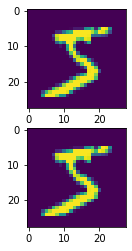

In [16]:
import gzip, numpy as np, matplotlib.pyplot as plt

path = "C:/Users/d09am/Desktop/Courses/representation/"
side = 28

def training_images(size=None):
    with gzip.open(path+'/train-images-idx3-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        if size: images = images[:size,]
        return images


def training_labels(size=None):
    with gzip.open(path+'/train-labels-idx1-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        if size: labels = labels[:size,]
        return labels

def linear(X):
    x = X.reshape(-1, side*side)
    return x

def matrix(X):
    x = X.reshape(-1, side, side)
    return x

def normalize(X, val=255):
    X = np.float64(X)
    mu = X.mean()
    var = X.var()
    X = (X-mu)/var
    return X

def combine(X, Y, shuffle=True, size=None):
    Y = Y.reshape(Y.shape[0], 1)
    train_data = np.concatenate((X, Y), axis=1)
    if shuffle: np.random.shuffle(train_data)
    x, y = train_data[:,:-1], train_data[:,-1:]
    y_ = np.zeros((y.shape[0], 10))
    for i in range(y.shape[0]): y_[i][int(y[i][0])] = 1
    return x, y_

# size=int(2e2)
size = 2
images = training_images(size)
labels = training_labels(size)
images = linear(images)
plt.subplot('211')
plt.imshow(images[0].reshape(side, side))
images = normalize(images)
plt.subplot('212')
plt.imshow(images[0].reshape(side, side))
train_x, train_y = combine(images, labels)

In [48]:
side = 28
hidden_layers = 2
hidden_layer_size = [15, 11]
input_size = side*side
output_size = 10
activation = 'relu'
net = NN(
    input_size=input_size, output_size=output_size, 
    no_of_hid=hidden_layers, size_of_hiddens=hidden_layer_size,
    active=activation)
net.train(train_x, train_y, epochs=60000, rate=0.000001)

NOTE: Please try to give input as numpy array with defined shape eg: (2,1) and try to avoid shape like (2,)
epoch: 6000, cost: 0.308683916438645, 10% complete...
epoch: 12000, cost: 0.2288145622322053, 20% complete...
epoch: 18000, cost: 0.18417108246572308, 30% complete...
epoch: 24000, cost: 0.1549893491812076, 40% complete...
epoch: 30000, cost: 0.13474459344615428, 50% complete...
epoch: 36000, cost: 0.12024951599017215, 60% complete...
epoch: 42000, cost: 0.10963521702922832, 70% complete...
epoch: 48000, cost: 0.10170659997881162, 80% complete...
epoch: 54000, cost: 0.09566718775235247, 90% complete...
epoch: 60000, cost: 0.0909747689233193, 100% complete...


In [47]:
for i in range(min(10, size)):
    result = net.predict(train_x[i], symbols=[0,1,2,3,4,5,6,7,8,9])
#     print(result['symbol'], np.argmax(train_y[i]))
    print(result, np.argmax(train_y[i]))

{'out': array([[7.29272797e-02],
       [6.72903271e-05],
       [6.92466663e-08],
       [1.85165391e-07],
       [7.65185251e-01],
       [2.64457770e-02],
       [1.21876962e-01],
       [8.20594294e-03],
       [2.28069748e-05],
       [5.26843487e-03]]), 'pos': 4, 'var': 0.0506475329092511, 'symbol': 4} 5
{'out': array([[4.17194047e-02],
       [2.73376666e-06],
       [4.95715948e-10],
       [1.64609778e-09],
       [8.66700405e-01],
       [1.02330675e-02],
       [7.83399015e-02],
       [2.00677204e-03],
       [7.91074401e-07],
       [9.96921883e-04]]), 'pos': 4, 'var': 0.06591569782796416, 'symbol': 4} 0


In [510]:
a = np.zeros((10))
b = np.zeros((10))
a[3] = 1
b[2] = 1
print(sum(0.5*np.square(a-b)/10))

0.1


In [8]:
import numpy as np
a = np.array([1,2,3,4])
np.np.outer(a, a)

array([[ 1,  2,  3,  4],
       [ 2,  4,  6,  8],
       [ 3,  6,  9, 12],
       [ 4,  8, 12, 16]])